<a href="https://colab.research.google.com/github/durml91/Personal/blob/main/Transformer_implementation_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install einops
!pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518707 sha256=00befc56d569d4d0e864a08afed8ecf31c498fc423d08918e252f4651f48c6c4
  Stored in directory: /root/.cache/pip/wheels/f3/7a/25/f297f69029b5e4064e4736a0c4b3996a44cc27781c120bcb99
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.25
    Uninstalling jax-0.3.25:
      Successfully uninstalled jax-0.3.25


In [3]:
pip install -U jax jaxlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.25
    Uninstalling jaxlib-0.3.25:
      Successfully uninstalled jaxlib-0.3.25


In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import einops
import equinox as eqx
import optax
import tqdm

In [2]:
import functools
from typing import Dict, List, Mapping, Optional, Callable

#from datasets import load_dataset

from jaxtyping import Array, Float, Int

from tqdm import notebook as tqdm

import math

In [3]:
rand_key = jr.PRNGKey(2022)

### Transformer modules

GELU

In [4]:
class Lambda(eqx.Module):

    fn: Callable

    def __call__(self, x, *, key=None):
        return self.fn(x)

Attention

In [5]:
def causal_attention_mask(x):
    dim = x.shape[0]

    mask = jnp.ones((dim, dim), dtype=float)
    mask = jnp.tril(mask, k=0)
    return mask == 1

In [ ]:
# r=causal_attention_mask(jnp.ones((10,)))

In [ ]:
# AttentionBlock(62, 2, 0.0, 0.0, rand_key).make_attention_mask(r, jnp.ones((10,)), jnp.ones((10,)))

In [6]:
class AttentionBlock(eqx.Module):

    attention: eqx.nn.MultiheadAttention
    dropout: eqx.nn.Dropout
    num_heads: int = eqx.field(static=True)

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        self.num_heads = num_heads
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=d_model,
            use_query_bias=True,
            use_key_bias=True,
            use_value_bias=True,
            use_output_bias=True,
            dropout_p=attention_dropout_rate,
            key=key,
        )

        self.dropout = eqx.nn.Dropout(dropout_rate)


    def make_attention_mask(
        self, mask, q: Int[Array, "query_seq_len"], kv: Int[Array, "kv_seq_len"],
    ) -> Float[Array, "num_heads query_seq_len kv_seq_len"]:

        qsl = q.shape[0]
        kvsl = kv.shape[0]


        if mask.shape[0] != qsl:

            mask = einops.repeat(mask, " a b -> (a q) b", q = qsl)


        mask = jnp.where(mask, 1.0, 0.0)


        # if mask.shape[1] != kvsl:
        #     mask = einops.repeat(mask, " a b -> k", q = qsl)

        ###############################

        #mask = jnp.ones((qsl, kvsl))
        #mask = jnp.triu(mask, k=1)
        #mask *= -jnp.inf
        #mask = jnp.nan_to_num(mask, copy = False, nan=1.0)  # or nan=0.0
        #mask = jnp.where(mask==0., -jnp.inf, mask)

        #################################

        mask = jnp.expand_dims(mask, axis=-3)

        mask = jnp.repeat(mask, repeats=self.num_heads, axis=-3)

        return mask.astype(jnp.float32)


    def __call__(
        self,
        query: Float[Array, "seq_len d_model"],
        key_: Float[Array, "seq_len d_model"],
        value: Float[Array, "seq_len d_model"],
        mask,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "seq_len d_model"]:

        if mask is not None:
            mask = self.make_attention_mask(mask, query, key_)

        attention_key, dropout_key = (
            (None, None) if key is None else jr.split(key)
        )

        attention_output = self.attention(
              query=query,
              key_=key_,
              value=value,
              mask=mask,
              inference=not enable_dropout,
              key=attention_key
        )

        att_drop = self.dropout(attention_output, inference=not enable_dropout, key=dropout_key)

        return att_drop

In [ ]:
# logits = jr.normal(rand_key, shape=(10,10))

# mask = jnp.ones((10,10))
# mask = jnp.tril(mask, k=0)

# #mask = jnp.where(mask==1., -jnp.inf, mask)

# print(mask)
# print(logits)
# logits = jnp.where(mask, logits, jnp.finfo(logits.dtype).min)

# print(logits)

MLP Block

In [7]:
class FeedForwardBlock(eqx.Module):

    mlp: eqx.nn.Sequential    #could also use MLP if this way is more fiddly

    dropout: eqx.nn.Dropout


    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        dropout_rate: float,
        key: jr.PRNGKey,
    ):

        linear1, linear2 = jr.split(key)

        self.mlp = eqx.nn.Sequential([
            eqx.nn.Linear(in_features=d_model, out_features=intermediate_size, key=linear1),
            Lambda(jax.nn.gelu),
            eqx.nn.Linear(in_features=intermediate_size, out_features=d_model, key=linear2)
        ])

        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: Float[Array, "seq_len d_model"],
        enable_dropout: bool = True,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:


        feed_out = jax.vmap(self.mlp)(inputs)

        out_d = self.dropout(feed_out, inference=not enable_dropout, key=key)


        return out_d


Embedding table

In [8]:
class InputEmbeddings(eqx.Module):

  embedding: eqx.nn.Embedding
  d_model: int

  def __init__(
      self,
      d_model: int,
      vocab_size: int,
      key: jr.PRNGKey,
  ):
      self.d_model = d_model
      self.embedding = eqx.nn.Embedding(vocab_size, d_model, key=key)

  def __call__(self, x) -> Float[Array, "seq_len d_model"]:
    return self.embedding(x) * math.sqrt(self.d_model)

Positional encoding

In [9]:
class SinusoidalPosEmb(eqx.Module):
    pos_emb: jax.Array
    dropout: eqx.nn.Dropout


    def __init__(
        self,
        d_model: int,
        seq_len: int,
        dropout_rate: float
    ):
        self.dropout = eqx.nn.Dropout(dropout_rate)

        half_dim = d_model//2

        pe = jnp.zeros((seq_len, d_model))

        position = einops.repeat(jnp.arange(0 , seq_len), " s -> s r", r=half_dim)  #shape [seq_len, d_model/2]

        div_term = jnp.exp(jnp.arange(0, d_model, 2) * -(math.log(10_000) / d_model))  #shape [d_model/2]

        ins = jax.vmap(jnp.multiply, in_axes=(1, 0), out_axes=1)(position, div_term)  #shape [seq_len, d_model/2]


        pe = pe.at[:, 0::2].set(jnp.sin(ins))
        pe = pe.at[:, 1::2].set(jnp.cos(ins))


        #self.pos_emb = jnp.expand_dims(pe, axis=0)
        self.pos_emb = pe

    def __call__(
        self,
        x,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "seq_len d_model"]:

        x = x + jax.lax.stop_gradient(self.pos_emb[:x.shape[0], :])

        return self.dropout(x, inference=not enable_dropout, key=key)



####### need to freeze parameters use eqx.partition or try filter(static=True)

Visualisation

In [ ]:
import pandas as pd
import altair as alt

In [ ]:
def show_example(fn, args=[]):
    if __name__ == "__main__" :
        return fn(*args)

In [ ]:
def example_positional():
    pe = SinusoidalPosEmb(20, 5000, 0)
    y = pe(jnp.zeros((100, 20), dtype=jnp.float32))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[:, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

show_example(example_positional)

(100, 20) (5000, 20)


alt.Chart(...)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgb
matplotlib.rcParams['lines.linewidth']=2.0
import seaborn as sns
sns.reset_orig()

<ipython-input-148-e9e448fab539>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


<Figure size 640x480 with 0 Axes>

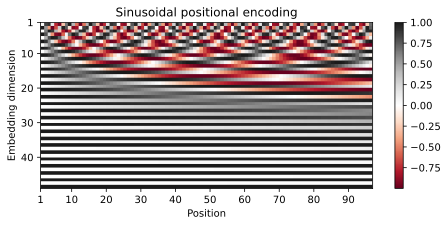

In [ ]:
encod_block = SinusoidalPosEmb(d_model=48, seq_len=96, dropout_rate=0.0)
#pe = jnp.transpose(jnp.squeeze(encod_block.pos_emb))
pe = jnp.transpose(encod_block.pos_emb)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos=ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1]+1, pe.shape[0]+1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position")
ax.set_ylabel("Embedding dimension")
ax.set_title("Sinusoidal positional encoding")

ax.set_xticks([1]+[i*10 for i in range(1, 1+pe.shape[1] //10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])

plt.show()

Encoder Block

In [10]:
class EncoderLayer(eqx.Module):

    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        attention_key, ff_key = jr.split(key)

        self.attention_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=attention_key,
        )

        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )

        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "seq_len d_model"],
        mask: Optional[Int[Array, "seq_len"]] = None,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        attn_key, ff_key = (None, None) if key is None else jr.split(key)

        ln_inputs_1 = jax.vmap(self.layer_norm_1)(inputs)
        inputs = inputs + self.attention_block(
            ln_inputs_1, ln_inputs_1, ln_inputs_1, mask, enable_dropout=enable_dropout, key=attn_key
        )

        ln_inputs_2 = jax.vmap(self.layer_norm_2)(inputs)
        inputs = inputs + self.ff_block(
            ln_inputs_2, enable_dropout=enable_dropout, key=ff_key
        )

        return inputs

Encoder

In [68]:
class Encoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[EncoderLayer]


    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

      embedder_key, layer_key = jr.split(key, num=2)

      self.embedder_block = InputEmbeddings(
          d_model, vocab_size, key=embedder_key
      )

      self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)

      layer_keys = jr.split(layer_key, num=num_layers)

      self.layers = [
          EncoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]



    def __call__(
          self,
          tokens: Int[Array, " seq_len"],
          mask,
          *,
          enable_dropout: bool = False,
          key: Optional[jr.PRNGKey] = None,
    ):

          ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

          embed_inputs = self.embedder_block(tokens)
          x = self.pos_embed(embed_inputs, enable_dropout=enable_dropout, key=ps_emb_key)



          # if key is not None:
          #   for layer, subkey in zip(self.layers, jr.split(key, len(self.layers))):

          #         x = layer(x, mask, enable_dropout=enable_dropout, key=subkey)
          # else:
          #   for layer in self.layers:
          #       x = layer(x, mask, enable_dropout=enable_dropout)

          for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, mask, enable_dropout=enable_dropout, key=cl_key)

          return x

Decoder Block

In [12]:
class DecoderLayer(eqx.Module):

    self_att_block: AttentionBlock
    cross_att_block: AttentionBlock
    ff_block: FeedForwardBlock

    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    layer_norm_3: eqx.nn.LayerNorm

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        self_att_key, cross_att_key, ff_key = jr.split(key, num=3)

        self.self_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=self_att_key,
        )

        self.cross_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=cross_att_key,
        )

        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )

        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_3 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "seq_len d_model"],
        encoder_output,
        src_mask,
        tgt_mask,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):

        self_attn_key, cross_attn_key, ff_key = (None, None, None) if key is None else jr.split(key, num=3)


        ln_inputs_1 = jax.vmap(self.layer_norm_1)(inputs)
        inputs = inputs + self.self_att_block(
            ln_inputs_1, ln_inputs_1, ln_inputs_1, tgt_mask, enable_dropout=enable_dropout, key=self_attn_key
        )


        ln_inputs_2 = jax.vmap(self.layer_norm_2)(inputs)
        inputs = inputs + self.cross_att_block(
            ln_inputs_2, encoder_output, encoder_output, src_mask, enable_dropout=enable_dropout, key=cross_attn_key
        )


        ln_inputs_3 = jax.vmap(self.layer_norm_3)(inputs)
        inputs = inputs + self.ff_block(
            ln_inputs_3, enable_dropout=enable_dropout, key=ff_key
        )

        return inputs

Decoder

In [69]:
class Decoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[DecoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_heads: int,
        num_layers: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):


        embedder_key, layer_key = jr.split(key, num=2)

        self.embedder_block = InputEmbeddings(
          d_model, vocab_size, embedder_key
        )

        self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)

        layer_keys = jr.split(layer_key, num=num_layers)

        self.layers = [
          DecoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
        self,
        x,
        encoder_output,
        src_mask,
        tgt_mask,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):

        ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)


        embed_inputs = self.embedder_block(x)
        x = self.pos_embed(embed_inputs, key=ps_emb_key)

        # if key is not None:
        #     for layer, subkey in zip(self.layers, jr.split(key, len(self.layers))):

        #           x = layer(x, encoder_output, src_mask, tgt_mask, key=subkey)
        # else:
        #     for layer in self.layers:
        #         x = layer(x, encoder_output, src_mask, tgt_mask)


        for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, encoder_output, src_mask, tgt_mask, enable_dropout=enable_dropout, key=cl_key)


        return x

Final Layer

In [14]:
class Out_Projection_Layer(eqx.Module):

    proj: eqx.nn.Linear

    def __init__(
        self,
        d_model:int,
        vocab_size: int,
        key: jr.PRNGKey
    ):

        self.proj = eqx.nn.Linear(in_features=d_model, out_features=vocab_size, key=key)

    def __call__(
        self,
        x
    ) -> Int[Array, "seq_len vocab_size"]:
        out = jax.vmap(self.proj)(x)
        #return jax.nn.log_softmax(out, axis=-1)
        return out


Transformer

In [ ]:
# class Transformer(eqx.Module):

#     encoder: Encoder
#     decoder: Decoder

#     out_proj: Out_Projection_Layer


#     def __init__(
#         self,
#         config: Mapping,
#         key: jr.PRNGKey
#     ):

#         encoder_key, decoder_key, out_proj_key = jr.split(key, num=3)

#         self.encoder = Encoder(
#             vocab_size=config["src_vocab_size"],
#             d_model=config["d_model"],
#             seq_len=config["src_seq_len"],
#             intermediate_size=config["intermediate_size"],
#             num_layers=config["num_hidden_layers"],
#             num_heads=config["num_attention_heads"],
#             dropout_rate=config["hidden_dropout_prob"],
#             attention_dropout_rate=config["attention_dropout_prob"],
#             key=encoder_key,
#         )

#         self.decoder = Decoder(
#             vocab_size=config["tgt_vocab_size"],
#             d_model=config["d_model"],
#             seq_len=config["tgt_seq_len"],
#             intermediate_size=config["intermediate_size"],
#             num_layers=config["num_hidden_layers"],
#             num_heads=config["num_attention_heads"],
#             dropout_rate=config["hidden_dropout_prob"],
#             attention_dropout_rate=config["attention_dropout_prob"],
#             key=decoder_key,
#         )

#         self.out_proj = Out_Projection_Layer(
#             d_model=config["d_model"],
#             vocab_size=config["tgt_vocab_size"],
#             key=out_proj_key)

#     def __call__(
#         self,
#         src,
#         src_mask,
#         tgt,
#         tgt_mask,
#         key
#     ):
#         enc_key, dec_key = jr.split(key, num=2)

#         #encode
#         enc = self.encoder(src, src_mask, key=enc_key)

#         #decode
#         dec = self.decoder(tgt, enc, src_mask, tgt_mask, key=dec_key)

#         #out projection
#         output = self.out_proj(dec)

#         return output

In [70]:
class Transformer(eqx.Module):

    encoder: Encoder
    decoder: Decoder

    out_proj: Out_Projection_Layer


    def __init__(
        self,
        config: Mapping,
        key: jr.PRNGKey
    ):

        encoder_key, decoder_key, out_proj_key = jr.split(key, num=3)

        self.encoder = Encoder(
            vocab_size=config["src_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["src_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=encoder_key,
        )

        self.decoder = Decoder(
            vocab_size=config["tgt_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["tgt_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=decoder_key,
        )

        self.out_proj = Out_Projection_Layer(
            d_model=config["d_model"],
            vocab_size=config["tgt_vocab_size"],
            key=out_proj_key)


    def encode(self,
               src,
               src_mask,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.encoder(src, src_mask, enable_dropout=enable_dropout, key=key)

    def decode(self,
               enc,
               src_mask,
               tgt,
               tgt_mask,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.decoder(tgt, enc, src_mask, tgt_mask, enable_dropout=enable_dropout, key=key)

    def project(self, x):
        return self.out_proj(x)

Configuration

In [ ]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 128,     # - 512
    "num_hidden_layers": 2,   #N - 6
    "num_attention_heads": 2,   #h - 8
    "intermediate_size": 512,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
}

Test

In [ ]:
new_config = {"src_vocab_size": 11,
    "tgt_vocab_size": 11,
    "src_seq_len": 10,
    "tgt_seq_len": 1}

#src_seq_len may make sense but tgt_seq_len constantly changes

In [ ]:
gpt_config.update(new_config)

In [ ]:
test_model = Transformer(gpt_config, rand_key)

In [ ]:
# test_model.encoder.layers[0].attention_block

In [ ]:
src = jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype= int)
src_mask = jnp.ones((1,10))
#src_mask = jnp.array([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0.]])


memory = test_model.encode(src, src_mask, rand_key)

In [ ]:
ys = jnp.zeros((1), dtype= int)
out = test_model.decode(memory, src_mask, ys, causal_attention_mask(ys), rand_key)


prob = test_model.project(out)

In [ ]:
prob.shape

(1, 11)

In [ ]:
h_prob = jnp.argmax(prob)

In [ ]:
os = jnp.concatenate([ys, jnp.array([h_prob])])

In [ ]:
src = jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype= int)
src_mask = jnp.ones((1,10))

memory = test_model.encode(src, src_mask, rand_key)

ys = jnp.zeros((1), dtype= int)

for i in range(9):
    out = test_model.decode(memory, src_mask, ys, causal_attention_mask(ys), rand_key)
    prob = test_model.project(out)
    h_prob = jnp.argmax(prob)
    ys = jnp.concatenate([ys, jnp.array([h_prob])])

print("Model Prediction:", ys)

Model Prediction: [0 6 6 6 6 6 6 6 6 6]


Training and datasets

In [ ]:
!pip install datasets[jax]
!pip install tokenizers

In [16]:
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

In [17]:
def get_all_sentences(ds, lang):
    for item in ds:
        yield item['translation'][lang]

In [18]:
def get_or_build_tokenizer(ds, lang):
    tokenizer_path = Path("tokenizer_{0}.json".format(lang))

    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]","[PAD]","[SOS]","[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

In [ ]:
# class BilingualDataset(eqx.Module):

#     ds: dict
#     tokenizer_src: Tokenizer
#     tokenizer_tgt: Tokenizer
#     src_lang: str
#     tgt_lang: str

#     sos_token: jnp.array
#     eos_token: jnp.array
#     pad_token: jnp.array


#     def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):

#         self.ds = ds
#         self.tokenizer_src = tokenizer_src
#         self.tokenizer_tgt = tokenizer_tgt

#         self.src_lang = src_lang
#         self.tgt_lang = tgt_lang

#         self.sos_token = jnp.array([tokenizer_src.token_to_id("[SOS]")], dtype=int) # get sos token id from tokeniser - would be array of shape [1,]
#         self.eos_token = jnp.array([tokenizer_src.token_to_id("[EOS]")], dtype=int)
#         self.pad_token  = jnp.array([tokenizer_src.token_to_id("[PAD]")], dtype=int)

#     def __len__(self):
#         return len(self.ds)

#     def __getitem__(self, index):



#         src_target_pair =  self.ds[set(index)]
#         src_text = src.src_target_pair['translation'][self.src_lang]
#         tgt_text = src_target_pair['translation'][self.tgt_lang]

#         enc_input_tokens = self.tokenizer_src.encode(src_text).ids
#         dec_input_tokens =  self.tokenizer_tgt.encode(tgt_text).ids

#         enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
#         dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

#         if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
#             raise ValueError('Sentence is too long')

#         # add SOS and EOS to source text
#         encoder_input = jnp.concatenate([
#             self.sos_token,
#             jnp.array(enc_input_tokens, dtype = int),
#             self.eos_token,
#             jnp.array([self.pad_token] * enc_num_padding_tokens, dtype=int)
#         ])

#         # add SOS to decoder input
#         decoder_input = jnp.concatenate([
#             self.sos_token,
#             jnp.array(dec_input_tokens, dtype=int),
#             jnp.array([self.pad_token] * dec_num_padding_tokens, dtype=int)
#         ])

#         # add EOS to expected decoder output

#         label = jnp.concatenate([
#             jnp.array(dec_input_tokens, dtype=int),
#             self.eos_token,
#             jnp.array([self.pad_token] * dec_num_padding_tokens, dtype=int)
#         ])


#         assert encoder_input.size(0) == self.seq_len
#         assert decoder_input.size(0) == self.seq_len
#         assert label.size(0) == self.seq_len

#         return {
#             "encoder_input": encoder_input, # (seq_len)
#             "decoder_input": decoder_input, # (seq_len)
#             "encoder_mask": jnp.expand_dims((encoder_input!= self.pad_token), axis=0),  # (1, seq_len)
#             "decoder_mask": jnp.expand_dims((encoder_input!= self.pad_token), axis=0) & causal_attention_mask(decoder_input.shape[0]), # (1 seq_len) & (seq_len seq_len)
#             "src_text": src_text,
#             "tgt_mask": tgt_text
#         }





In [ ]:
# tokenizer_src.encode(train_ds_raw["translation"][0]["en"]).ids

In [19]:
def process_ds(ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
    sos_token = jnp.array([tokenizer_src.token_to_id("[SOS]")], dtype=int) # get sos token id from tokeniser - would be array of shape [1,]
    eos_token = jnp.array([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.array([tokenizer_src.token_to_id("[PAD]")], dtype=int)


    # src_text = []
    # tgt_text = []
    # for i in range(len(ds)):
    #     src_text.append([ds['translation'][i][src_lang]])
    #     tgt_text.append([ds['translation'][i][tgt_lang]])

    src_text = ds['translation'][src_lang]
    tgt_text = ds['translation'][tgt_lang]

    enc_input_tokens = tokenizer_src.encode(src_text).ids
    dec_input_tokens =  tokenizer_tgt.encode(tgt_text).ids

    enc_num_padding_tokens = seq_len - len(enc_input_tokens) - 2
    dec_num_padding_tokens = seq_len - len(dec_input_tokens) - 1

    if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
        raise ValueError('Sentence is too long')





    # add SOS and EOS to source text
    encoder_input = jnp.concatenate([
        sos_token,
        jnp.array(enc_input_tokens),
        eos_token,
        jnp.repeat(pad_token, enc_num_padding_tokens)
    ])

    # add SOS to decoder input
    decoder_input = jnp.concatenate([
        sos_token,
        jnp.array(dec_input_tokens, dtype=int),
        jnp.repeat(pad_token, dec_num_padding_tokens)
    ])

    # add EOS to expected decoder output

    label = jnp.concatenate([
        jnp.array(dec_input_tokens, dtype=int),
        eos_token,
        jnp.repeat(pad_token, dec_num_padding_tokens)
    ])

    assert encoder_input.shape[0] == seq_len
    assert decoder_input.shape[0] == seq_len
    assert label.shape[0] == seq_len

    encoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0)  # (1, seq_len)
    decoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0) & causal_attention_mask(decoder_input) # (1 seq_len) & (seq_len seq_len)


    return encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text

    # return {
    #     "encoder_input": encoder_input, # (seq_len)
    #     "decoder_input": decoder_input, # (seq_len)
    #     "encoder_mask": jnp.expand_dims((encoder_input!= pad_token), axis=0),  # (1, seq_len)
    #     "decoder_mask": jnp.expand_dims((encoder_input!= pad_token), axis=0) & causal_attention_mask(decoder_input.shape[0]), # (1 seq_len) & (seq_len seq_len)
    #     "src_text": src_text,
    #     "tgt_mask": tgt_text
    # }




In [ ]:
# def batch_proc_ds(ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len, batch_size):
#     encoder_inputs = []
#     decoder_inputs = []
#     encoder_mask = []
#     decoder_mask = []
#     label = []
#     src_text = []
#     tgt_text = []
#     for i in range(batch_size):
#         id = ds["id"][i]
#         trans = ds["translation"][0]
#         new_dict = {"id":id, "translation":trans}


#         encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(new_dict, tokenizer_src, tokenizer_tgt, "en", "it", "350")


#         encoder_inputs.append(encoder_input)
#         decoder_inputs.append(decoder_input)
#         encoder_mask.append(encoder_mask)
#         decoder_mask.append(decoder_mask)
#         label.append(label)
#         src_text.append(src_text)
#         tgt_text.append(tgt_text)

#     encoder_inputs = jnp.asarray(encoder_inputs)
#     decoder_inputs = jnp.asarray(decoder_inputs)
#     encoder_mask = jnp.asarray(encoder_mask)
#     decoder_mask = jnp.asarray(decoder_mask)
#     label = jnp.asarray(label)
#     src_text = jnp.asarray(src_text)
#     tgt_text = jnp.asarray(tgt_text)

Data and Training

In [ ]:
# config stuff - seq_len: 350, lang_src: "en", "lang_tgt": "it", batch_size: "8"

In [20]:
ds_raw = load_dataset('opus_books', f'{"en"}-{"it"}', split='train')

ds_raw = ds_raw.with_format("jax")

    # # build tokenizer
tokenizer_src = get_or_build_tokenizer(ds_raw, "en")
tokenizer_tgt = get_or_build_tokenizer(ds_raw, "it")

# train validation split
train_ds_size = int(0.9 * len(ds_raw))
val_ds_size = len(ds_raw) - train_ds_size

Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-it/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


In [21]:
def rand_split(ds, train_size, val_size, key):
    ds_size = ds.shape[0]

    indices = jnp.arange(ds_size)
    perm = jr.permutation(rand_key, indices, independent=False)  # get random permutation of indices

    train_ind = perm[:train_size]
    val_ind = perm[train_size:]


    train_ds = ds[train_ind]
    val_ds = ds[val_ind]

    assert (len(train_ds["id"]) + len(val_ds["id"])) - ds_size == 0

    return (train_ds, val_ds)


In [22]:
train_ds_raw, val_ds_raw = rand_split(ds_raw, train_ds_size, val_ds_size, rand_key)

In [ ]:
# train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, "en", "it", "350")

In [ ]:
# val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, "en", "it", "350")

In [ ]:
# a = list(train_ds_raw.keys())[0]

In [ ]:
# len(train_ds_raw[a])

29098

In [23]:
# list(train_ds_raw.values())[1][1:3]

In [23]:
max_len_src = 0
max_len_tgt = 0

In [24]:
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation']["en"]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation']["it"]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')

Max length of source sentence: 309
Max length of target sentence: 274


In [ ]:
# !pip install jax-dataloader

In [ ]:
# import jax_dataloader as jdl

In [ ]:
# train_dataloader = jdl.DataLoaderJax(train_ds_raw, batch_size=8, shuffle=True)
# val_dataloader = jdl.DataLoaderJax(val_ds_raw, batch_size=1, shuffle=True)

In [ ]:
# import torch
# from torch.utils.data import DataLoader

In [ ]:
# train_dataloader = jdl.DataLoaderJax(train_ds, batch_size=8, shuffle=True)
# val_dataloader = jdl.DataLoaderJax(val_ds, batch_size=1, shuffle=True)

Training

In [63]:
import functools

In [71]:
#@eqx.filter_value_and_grad
def compute_loss(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key):   # key
    batch_size = encoder_inputs.shape[0]
    batch_keys = jr.split(key, num= 2* batch_size)

    encoder_output = jax.vmap(model.encode, in_axes=(0, 0, None, 0))(encoder_inputs, encoder_masks, True, batch_keys[0:8])
    #encoder_output = jax.vmap(functools.partial(model.encode, enable_dropout=True), in_axes=(0, 0, 0))(encoder_inputs, encoder_masks, batch_keys[0:8])


    decoder_output = jax.vmap(model.decode, in_axes=(0, 0, 0, 0, None, 0))(encoder_output, encoder_masks, decoder_inputs, decoder_masks, True, batch_keys[8:16])
    proj_output = jax.vmap(model.project, in_axes=0)(decoder_output)


    logits = einops.rearrange(proj_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
    labels = einops.rearrange(labels, " b s -> (b s)")

    pad_pos = tokenizer_tgt.token_to_id("[PAD]")
    logits = logits.at[:, pad_pos].set(-10**9)


    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels)



    return (jnp.sum(loss, axis=0))/(logits.shape[1]-1)

In [56]:
@eqx.filter_jit
def make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt_update, key):  # key
    key, new_key = jr.split(key)
    loss_fn = eqx.filter_value_and_grad(compute_loss)
    loss, grads = loss_fn(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key) # key
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state, new_key

In [ ]:
# import functools

# def make_eval_step(model, inputs):
#     return jax.vmap(functools.partial(model, enable_dropout=False))(inputs)

In [ ]:
# training config - lr = 10**-4, num_epochs = 20

In [27]:
from tqdm import notebook as tqdm

In [28]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 128,     # - 512
    "num_hidden_layers": 2,   #N - 6
    "num_attention_heads": 2,   #h - 8
    "intermediate_size": 512,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
}

In [29]:
new_config = {"src_vocab_size": tokenizer_src.get_vocab_size(),
    "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
    "src_seq_len": 350,
    "tgt_seq_len": 350}

#src_seq_len may make sense but tgt_seq_len constantly changes

gpt_config.update(new_config)

In [74]:
def dataloader(data, batch_size, *, key):
    dataset_size = len(data["id"])
    indices = jnp.arange(dataset_size)
    while True:   # loop forever
        perm = jr.permutation(key, indices)  # get random permutation of indices
        (key, ) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            new_dict = {"id": [list(data["id"])[i] for i in batch_perm], "translation": [list(data["translation"])[j] for j in batch_perm]}
            yield new_dict
            start = end
            end = start + batch_size

In [30]:
# training

epochs = 20
batch_size = 8
learning_rate = 1e-4

In [92]:
# model initialisation

init_model = Transformer(gpt_config, rand_key)

In [ ]:
# for epoch in range(epochs):
#     with tqdm.tqdm(
#         train_ds.iter(batch_size=batch_size, drop_last_batch=True),
#         total=train_ds.num_rows // batch_size
#         unit="steps",
#         desc=f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#       for batch in tqdm_epoch:
#           token_ids, token_type_ids = batch["input_ids"], batch["token_type_ids"]
#           label = batch['label']

#           inputs = {
#               "token_ids": token_ids,
#               "segment_ids": token_type_ids,
#               "label": label,
#           }

#           loss, model, opt_state, train_key =

In [ ]:
# v = dataloader(train_ds_raw, batch_size, key=rand_key)
# print(next(v))
# print(next(v))

In [166]:
def xavier_init(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, param.shape)
    return params

In [167]:
def xavier_init_b(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, (1, param.shape[0]))
    params = jnp.squeeze(params, axis=0)
    return params

In [168]:
def init_parameters(model, init_fn, init_fn_b, key):

    wkey, bkey, ekey = jr.split(key, 3)

    is_linear = lambda x: isinstance(x, eqx.nn.Linear)

    get_weights = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey) for weight, subkey in zip(weights, jr.split(wkey, len(weights)))]
    model_w = eqx.tree_at(get_weights, model, new_weights)

    get_biases = lambda m: [x.bias for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    biases = get_biases(model_w)
    new_biases = [init_fn_b(bias, subkey) for bias, subkey in zip(biases, jr.split(bkey, len(biases)))]
    model_wb = eqx.tree_at(get_biases, model_w, new_biases)




    is_embedding = lambda x: isinstance(x, eqx.nn.Embedding)

    get_embs = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_embedding) if is_embedding(x)]
    embs = get_embs(model_wb)
    new_embs = [init_fn(embedding, subkey) for embedding, subkey in zip(embs, jr.split(ekey, len(embs)))]

    new_model = eqx.tree_at(get_embs, model_wb, new_embs)

    return new_model

In [170]:
model = init_parameters(init_model, xavier_init, xavier_init_b, rand_key)

In [ ]:
model.encoder.layers[0].ff_block.mlp.layers[0].weight

In [ ]:
new_model.encoder.layers[0].ff_block.mlp.layers[0].weight

In [ ]:
model.out_proj.proj.bias

In [ ]:
new_model.out_proj.proj.bias

In [ ]:
model.encoder.embedder_block.embedding.weight

In [ ]:
new_model.encoder.embedder_block.embedding.weight

In [ ]:
# train_ds_raw["translation"][train_ds_raw["id"].index("5002")]

In [83]:
# setup optax

opt = optax.adam(learning_rate=learning_rate)
opt = optax.chain(optax.clip_by_global_norm(1.0), opt)


opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [84]:
train_key, loader_key = jr.split(rand_key, 2)

In [80]:
from tqdm import notebook as tqdm

In [85]:
for epoch in range(epochs):
    ds_load  = dataloader(train_ds_raw, batch_size, key=loader_key)
    with tqdm.tqdm(
        ds_load,
        total = len(train_ds_raw["translation"])// batch_size,
        unit = "steps",
        desc = f"Epoch {epoch+1}/{epochs}",
    ) as tqdm_epoch:

        for data in tqdm_epoch:

            encoder_inputs = []
            decoder_inputs = []
            encoder_masks = []
            decoder_masks = []
            labels = []

            for i in range(batch_size):
                id = data["id"][i]
                trans = data["translation"][i]
                new_dict = {"id":id, "translation":trans}

                encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(new_dict, tokenizer_src, tokenizer_tgt, "en", "it", 350)


                encoder_inputs.append(encoder_input)
                decoder_inputs.append(decoder_input)
                encoder_masks.append(encoder_mask)
                decoder_masks.append(decoder_mask)
                labels.append(label)



            encoder_inputs = jnp.asarray(encoder_inputs)
            decoder_inputs = jnp.asarray(decoder_inputs)

            encoder_masks = jnp.asarray(encoder_masks)
            decoder_masks = jnp.asarray(decoder_masks)

            labels = jnp.asarray(labels)


            loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

            tqdm_epoch.set_postfix(loss = jnp.sum(loss).item())

Epoch 1/20:   0%|          | 0/3637 [00:00<?, ?steps/s]

KeyboardInterrupt: ignored

In [ ]:
# for epoch in range(1):

#     for data in dataloader(train_ds_raw, batch_size, key=rand_key):


#         encoder_inputs = []
#         decoder_inputs = []
#         encoder_masks = []
#         decoder_masks = []
#         labels = []
#         # src_text = []
#         # tgt_text = []
#         for i in range(batch_size):
#             id = data["id"][i]
#             trans = data["translation"][i]
#             new_dict = {"id":id, "translation":trans}

#             encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(new_dict, tokenizer_src, tokenizer_tgt, "en", "it", 350)


#             encoder_inputs.append(encoder_input)
#             decoder_inputs.append(decoder_input)
#             encoder_masks.append(encoder_mask)
#             decoder_masks.append(decoder_mask)
#             labels.append(label)



#         encoder_inputs = jnp.asarray(encoder_inputs)
#         decoder_inputs = jnp.asarray(decoder_inputs)

#         encoder_masks = jnp.asarray(encoder_masks)
#         decoder_masks = jnp.asarray(decoder_masks)

#         labels = jnp.asarray(labels)





#         value, model, opt_state = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update)

In [56]:
input = jnp.ones(shape=(5,10))

In [108]:
input = jr.normal(rand_key, shape=(5,10))

In [109]:
input.shape

(5, 10)

In [110]:
nn = eqx.nn.Linear(in_features = 10, out_features = 20, key=rand_key)

In [111]:
output = jax.vmap(nn, in_axes=0)(input)

In [112]:
output

Array([[-0.37906468, -1.0063015 , -0.21137206,  0.02303558, -0.1972262 ,
        -0.75060046,  0.527413  ,  0.344437  ,  0.21343544,  0.6526581 ,
         0.54060686,  0.44028497, -0.41443714,  0.10939068, -0.00452331,
         0.02509025,  0.49180877,  0.15658364,  0.04874423,  0.41236448],
       [-0.36492354,  0.3071353 , -0.60653055, -0.0045495 ,  0.42441383,
        -0.15565202, -0.3773985 , -0.28318876,  0.76588583,  0.12730302,
         0.03839349,  0.8638524 ,  0.20970938,  0.00418374,  0.34662133,
         0.14377964,  0.9250995 ,  0.21787138,  0.03061348,  0.21865407],
       [ 0.26298878, -0.7172289 , -0.5945681 ,  0.17848754,  1.5984058 ,
         1.5583028 , -0.23757678,  0.06813183,  0.6729004 , -0.45138812,
        -0.6235001 ,  0.59601855,  0.05584368,  0.2717495 , -0.13302737,
         1.2461132 ,  0.806003  , -0.21098025, -0.01917696,  0.18773998],
       [-1.0521381 , -0.47560576, -1.6197001 , -0.28294188,  0.538607  ,
        -0.6269661 , -0.06177825,  0.17743437,  

In [128]:
output.shape

(5, 20)

In [113]:
weight = nn.weight

In [114]:
weight.shape

(20, 10)

In [115]:
bias = nn.bias

In [116]:
bias.shape

(20,)

In [117]:
input[0].shape

(10,)

In [118]:
x1 = jnp.matmul(weight, input[0]) + bias

In [119]:
(jnp.matmul(input[0], jnp.transpose(weight)) + bias)

Array([-0.37906468, -1.0063014 , -0.21137208,  0.02303558, -0.19722617,
       -0.75060046,  0.527413  ,  0.34443706,  0.21343544,  0.65265816,
        0.54060686,  0.44028497, -0.41443714,  0.10939068, -0.00452331,
        0.02509028,  0.49180877,  0.15658362,  0.04874426,  0.41236454],      dtype=float32)

In [120]:
x1.shape

(20,)

In [121]:
x1

Array([-0.37906468, -1.0063015 , -0.21137203,  0.02303561, -0.1972262 ,
       -0.75060046,  0.527413  ,  0.34443706,  0.21343541,  0.65265816,
        0.54060686,  0.44028497, -0.41443717,  0.10939069, -0.00452334,
        0.0250903 ,  0.4918088 ,  0.15658364,  0.04874423,  0.41236448],      dtype=float32)

In [122]:
x = jnp.einsum("rS,Se -> re", input, jnp.transpose(weight))

In [123]:
x += bias

In [124]:
x.shape

(5, 20)

In [125]:
x

Array([[-0.37906468, -1.0063014 , -0.21137208,  0.02303558, -0.19722617,
        -0.75060046,  0.527413  ,  0.34443706,  0.21343544,  0.65265816,
         0.54060686,  0.44028497, -0.41443714,  0.10939068, -0.00452331,
         0.02509028,  0.49180877,  0.15658364,  0.04874423,  0.41236454],
       [-0.36492354,  0.3071353 , -0.60653055, -0.00454947,  0.42441383,
        -0.15565202, -0.3773985 , -0.28318876,  0.76588583,  0.12730299,
         0.0383935 ,  0.86385244,  0.2097094 ,  0.00418371,  0.34662127,
         0.14377962,  0.9250995 ,  0.21787138,  0.03061354,  0.21865408],
       [ 0.26298878, -0.717229  , -0.5945681 ,  0.17848754,  1.5984056 ,
         1.5583028 , -0.23757678,  0.06813182,  0.6729003 , -0.45138818,
        -0.6235001 ,  0.5960185 ,  0.05584372,  0.2717495 , -0.13302736,
         1.2461131 ,  0.806003  , -0.21098025, -0.01917696,  0.18773998],
       [-1.0521381 , -0.47560573, -1.6197001 , -0.28294188,  0.538607  ,
        -0.6269661 , -0.06177825,  0.1774344 ,  

In [126]:
test = jnp.transpose(jnp.einsum("rS,Se -> re", weight, jnp.transpose(input))) + bias

In [127]:
test

Array([[-0.37906468, -1.0063015 , -0.21137206,  0.02303558, -0.1972262 ,
        -0.75060046,  0.527413  ,  0.344437  ,  0.21343544,  0.6526581 ,
         0.54060686,  0.44028497, -0.41443714,  0.10939068, -0.00452331,
         0.02509025,  0.49180877,  0.15658364,  0.04874423,  0.41236448],
       [-0.36492354,  0.3071353 , -0.60653055, -0.0045495 ,  0.42441383,
        -0.15565202, -0.3773985 , -0.28318876,  0.76588583,  0.12730302,
         0.03839349,  0.8638524 ,  0.20970938,  0.00418374,  0.34662133,
         0.14377964,  0.9250995 ,  0.21787138,  0.03061348,  0.21865407],
       [ 0.26298878, -0.7172289 , -0.5945681 ,  0.17848754,  1.5984058 ,
         1.5583028 , -0.23757678,  0.06813183,  0.6729004 , -0.45138812,
        -0.6235001 ,  0.59601855,  0.05584368,  0.2717495 , -0.13302737,
         1.2461132 ,  0.806003  , -0.21098025, -0.01917696,  0.18773998],
       [-1.0521381 , -0.47560576, -1.6197001 , -0.28294188,  0.538607  ,
        -0.6269661 , -0.06177825,  0.17743437,  